In [21]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import sys
sys.path.append('../lib')
import Powerspectra


In [22]:
from importlib import reload
reload(Powerspectra)

<module 'Powerspectra' from 'c:\\Users\\jschulz\\Desktop\\Git_file\\mbr_relevant_code\\simulations\\../lib\\Powerspectra.py'>

In [3]:
def forcefield(x, k):
    return -x * k

def make_trajectory(time, dt, k=1, Diffusion_particle=1, detection_noise=0):
    # Compute the number of steps
    n_steps = int(time / dt)
    
    # Allocate arrays for x values and forces
    trajectory_particle = np.empty(n_steps + 1)
    times = np.arange(0, time + dt, dt)
    
    # Initialize the first value of x
    trajectory_particle[0] = np.random.normal()
    
    # Precalculate random terms for efficiency
    sqrt_dt_diffusion = np.sqrt(2 * Diffusion_particle * dt)
    rand_terms_trajectory = np.random.normal(scale=sqrt_dt_diffusion, size=n_steps)
    rand_terms_detection = np.random.normal(scale=detection_noise, size=n_steps)
    
    for i in range(n_steps):
        force = forcefield(trajectory_particle[i], k)
        trajectory_particle[i + 1] = trajectory_particle[i] + force * dt + rand_terms_trajectory[i]
        
    # Add detection noise
    trajectory_particle[1:] += rand_terms_detection
    
    return times, trajectory_particle

def powerspectrum(trajectory, dt, k_max=None):
    # Compute the FFT of the trajectory
    trajectory_fft = np.fft.fft(trajectory)
    if k_max != None:
        k_max = min(k_max, len(trajectory) // 2)
    else:
        k_max = len(trajectory) // 2

    f_ks = np.arange(1, k_max+1) /(len(trajectory) * dt)

    frequncy_indeces = np.arange(1, k_max+1)
    
    # Only consider up to k_max frequencies
    truncated_fft = trajectory_fft[frequncy_indeces]
    
    # Compute the power spectrum
    power_spectrum =dt* np.abs(truncated_fft)**2 /len(trajectory)
    

    
    return f_ks, power_spectrum

In [4]:
simulation_time = 10000
dt = 0.001
times, trajectory_particle = make_trajectory(simulation_time, dt, k=1, Diffusion_particle=1, detection_noise=0)


In [5]:
# Save
save_folder = r'//134.76.13.158/betzlab/Julian/Simulations/Spectrals/'
#np.save(save_folder+'trajectory_particle.npy', trajectory_particle)
#np.save(save_folder+'times.npy', times)

In [6]:

# Load
trajectory_particle = np.load(save_folder+'trajectory_particle.npy')
times = np.load(save_folder+'times.npy')

In [5]:
def smooth(data, N=10):
    kernel = np.ones(N) / N
    return np.convolve(data, kernel, 'same')



def average_trajectory(trajectory, times, dt):
    bin_size = int(dt / (times[1] - times[0]))
    reshaped_trajectory = trajectory[:len(trajectory)//bin_size * bin_size].reshape(-1, bin_size)
    reshaped_times = times[:len(times)//bin_size * bin_size].reshape(-1, bin_size)
    return np.mean(reshaped_trajectory, axis=1), np.mean(reshaped_times, axis=1)

def plot_data(f_ks_list, power_spectrum_list, N=1001):
    plt.figure(figsize=(10, 10))

    for f_ks, ps in zip(f_ks_list, power_spectrum_list):
        # Original data
        plt.plot(f_ks, ps, alpha=0.5, label=f'Original dt = {f_ks[1] - f_ks[0]:.4f}')
        # Smoothed data
        offset = N // 2
        plt.plot(f_ks[offset:-offset], smooth(ps, N), label=f'Smoothed dt = {f_ks[1] - f_ks[0]:.4f}')

    # Analytical
    plt.plot(f_ks_list[0], analytical_powerspectrum(f_ks_list[0]), 'k-', label='Analytical', linewidth=3)
    plt.yscale('log')
    plt.xlabel('Frequency')
    plt.ylabel('Power spectrum')
    plt.legend()
    plt.show()
def analytical_powerspectrum(f,Kbt_over_gamma=1, f_c=1/(2*np.pi)):
    return  Kbt_over_gamma /(2*np.pi**2) / (f_c**2 + f**2)
def analytical_blurry_powerspectrum(f, dt,Kbt_over_gamma=1, f_c=1/(2*np.pi)):
    return analytical_powerspectrum(f,Kbt_over_gamma=Kbt_over_gamma, f_c=f_c)*(np.sinc(f*dt))**2
def analytical_aliassed_powerspectrum(f, dt,N_alisasing=10,Kbt_over_gamma=1, f_c=1/(2*np.pi)):
    f_nyquist= 1/(2*dt)
    return_value = 0
    for n in range(-N_alisasing, N_alisasing+1):
        return_value += analytical_blurry_powerspectrum(f + 2*n*f_nyquist, dt,Kbt_over_gamma=Kbt_over_gamma, f_c=f_c)
    return return_value
def analytical_noisy_powerspectrum(f, dt,  Kbt_over_gamma=1, f_c=1/(2*np.pi), noise=0):
    f_nyquist= 1/(2*dt)
    return analytical_aliassed_powerspectrum(f,dt,  Kbt_over_gamma=Kbt_over_gamma, f_c=f_c) + noise**2 / (f_nyquist*2)


def fast_analytical_noisy_powerspectrum(f, dt, Kbt_over_gamma=1, f_c=1/(2*np.pi), noise=0, N_alisasing=10):
    f_nyquist = 1 / (2 * dt)
    n_values = np.arange(-N_alisasing, N_alisasing + 1)
    f_shifted = f[:, np.newaxis] + 2 * n_values * f_nyquist
    sinc_vals = (np.sinc(f_shifted*dt))**2
    denom = f_c**2 + f_shifted**2
    aliassed_sum = Kbt_over_gamma / (2 * np.pi**2) * (sinc_vals / denom).sum(axis=1)
    return aliassed_sum + noise**2 / (f_nyquist*2)

In [15]:
# Main code
dt_list = [0.1,0.01,0.001, 0.0001]
dt_list = [0.001]
avg_trajectory_list = []
avg_times_list = []

for dt in dt_list:
    avg_trajectory, avg_times = average_trajectory(trajectory_particle, times, dt)
    avg_trajectory_list.append(avg_trajectory)
    avg_times_list.append(avg_times)

f_ks_list = []
power_spectrum_list = []

for i in range(len(dt_list)):
    f_ks, power_spectrum = powerspectrum(avg_trajectory_list[i], dt_list[i])
    f_ks_list.append(f_ks)
    power_spectrum_list.append(power_spectrum)

In [16]:
N_smooth = 1001
smothed_power_spectrum_list = []
for i in range(len(dt_list)):
    smothed_power_spectrum_list.append(smooth(power_spectrum_list[i], N_smooth))


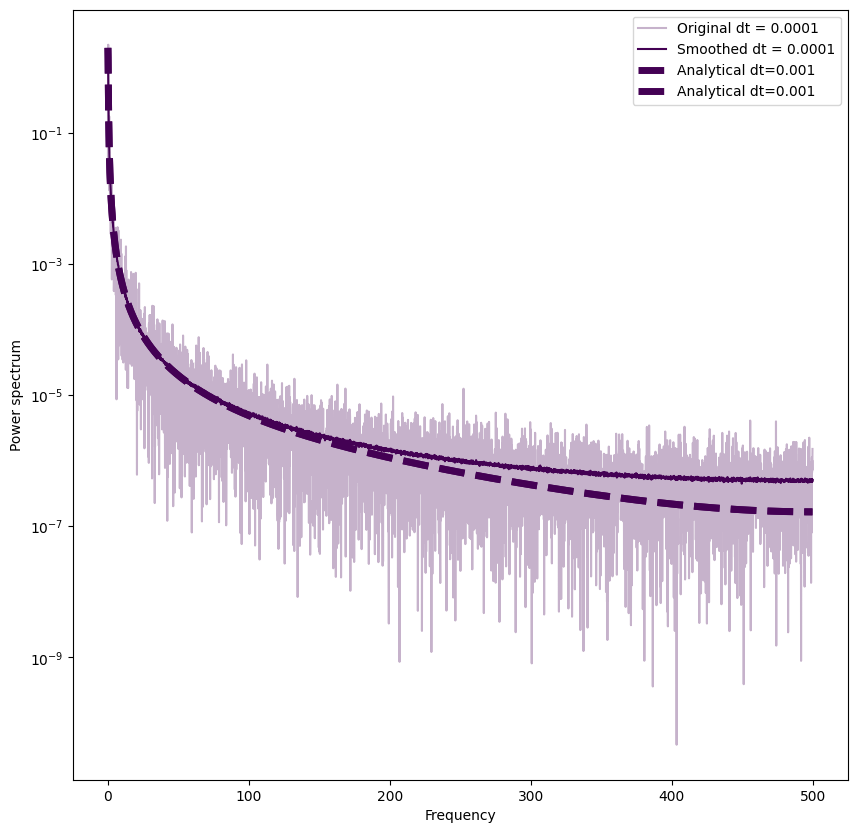

In [18]:
plt.figure(figsize=(10, 10))

N_plot_speedup = 1000
colors = plt.cm.viridis(np.linspace(0, 1, len(dt_list))) # Color map
for color, f_ks, ps, dt in zip(colors,f_ks_list, power_spectrum_list, dt_list):
    # Original data
    plt.plot(f_ks[::N_plot_speedup], ps[::N_plot_speedup], alpha=0.3, label=f'Original dt = {f_ks[1] - f_ks[0]:.4f}', color=color)
# Smoothed data
for color, f_ks, ps, dt in zip(colors,f_ks_list, smothed_power_spectrum_list, dt_list):
    plt.plot(f_ks[::N_plot_speedup], ps[::N_plot_speedup], label=f'Smoothed dt = {f_ks[1] - f_ks[0]:.4f}', color=color)

# Analytical
for color, f_ks, dt in zip(colors, f_ks_list, dt_list):
   plt.plot(f_ks[::N_plot_speedup], analytical_aliassed_powerspectrum(f_ks[::N_plot_speedup], dt), '--', label=f'Analytical dt={dt}', linewidth=5, color=color)

# fast analytical
for color, f_ks, dt in zip(colors, f_ks_list, dt_list):
    plt.plot(f_ks[::N_plot_speedup], fast_analytical_noisy_powerspectrum(f_ks[::N_plot_speedup], dt), '--', label=f'Analytical dt={dt}', linewidth=5, color=color)


plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power spectrum')
plt.legend()
plt.show()

In [8]:
dt = 0.0001
avg_trajectory, avg_times = average_trajectory(trajectory_particle, times,  dt)
noise_levels = [1, 0.1, 0.001, 0.0001]
# 1. Generate random noise once
random_noise = np.random.normal(0, 1, len(avg_trajectory))

# 2. Create noisy trajectories by scaling the noise by different levels
noisy_trajectories = [avg_trajectory + noise_level * random_noise for noise_level in noise_levels]

# Computing power spectrums for noisy trajectories
f_ks_noisy_list = []
power_spectrum_noisy_list = []
for noisy_traj in noisy_trajectories:
    f_ks, power_spectrum = powerspectrum(noisy_traj, dt) # Assuming dt and k_max are defined from previous code
    f_ks_noisy_list.append(f_ks)
    power_spectrum_noisy_list.append(power_spectrum)

In [25]:
from importlib import reload
reload(Powerspectra)

<module 'Powerspectra' from 'c:\\Users\\jschulz\\Desktop\\Git_file\\mbr_relevant_code\\simulations\\../lib\\Powerspectra.py'>

In [26]:
fit_results = []
for f_ks, power_spectrum in zip(f_ks_noisy_list, power_spectrum_noisy_list):
    fit_results.append(Powerspectra.fit_power_spectrum(f_ks, power_spectrum,bin_size=1001))

In [28]:
fit_results

[{'dt': {'value': 0.0001},
  'Kbt_over_gamma': {'value': 0.9972960886495617,
   'uncertainty': 0.0024116562193236147},
  'f_c': {'value': 0.16259744716747232, 'uncertainty': 0.0022867626769217855},
  'noise_param': {'value': 0.998978084060093,
   'uncertainty': 7.117758927986568e-05}},
 {'dt': {'value': 0.0001},
  'Kbt_over_gamma': {'value': 0.9981885271146738,
   'uncertainty': 0.0007657165528594003},
  'f_c': {'value': 0.16274413555770675, 'uncertainty': 0.002259928416217235},
  'noise_param': {'value': 0.09989903479363754,
   'uncertainty': 7.574608798128804e-06}},
 {'dt': {'value': 0.0001},
  'Kbt_over_gamma': {'value': 0.9977274149217591,
   'uncertainty': 0.00020942977491165174},
  'f_c': {'value': 0.16267231722887288, 'uncertainty': 0.0022558954822215274},
  'noise_param': {'value': 0.0011568944930250523,
   'uncertainty': 3.1211664122247746e-06}},
 {'dt': {'value': 0.0001},
  'Kbt_over_gamma': {'value': 0.9977148999582729,
   'uncertainty': 0.0002078298037002713},
  'f_c': {'va

: 

In [21]:
#print the fitting parameters
for fit_result, noise in zip(fit_results, noise_levels):
    print(f'dt: {dt:.4f}')
    print(f"fitted dt: {fit_result['dt']['value']:.4f} +/- {fit_result['dt']['uncertainty']:.4f}")
    print(f"noise: {noise:.4f}")
    print(f"fitted noise: {fit_result['noise_param']['value']:.4f} +/- {fit_result['noise_param']['uncertainty']:.4f}")
    print(f"Kbt_over_gamma: {1:.4f}")
    print(f"fitted Kbt_over_gamma: {fit_result['Kbt_over_gamma']['value']:.4f} +/- {fit_result['Kbt_over_gamma']['uncertainty']:.4f}")
    print(f"f_c: {1/(2*np.pi):.4f}")
    print(f"fitted f_c: {fit_result['f_c']['value']:.4f} +/- {fit_result['f_c']['uncertainty']:.4f}")
    print("#############################################")


dt: 0.0001
fitted dt: 0.0001 +/- 0.0168
noise: 1.0000
fitted noise: 0.9564 +/- 73.5258
Kbt_over_gamma: 1.0000
fitted Kbt_over_gamma: 0.9973 +/- 0.0764
f_c: 0.1592
fitted f_c: 0.1626 +/- 0.0724
#############################################
dt: 0.0001
fitted dt: 0.0001 +/- 0.0004
noise: 0.1000
fitted noise: 0.1048 +/- 0.2309
Kbt_over_gamma: 1.0000
fitted Kbt_over_gamma: 0.9981 +/- 0.0246
f_c: 0.1592
fitted f_c: 0.1627 +/- 0.0715
#############################################
dt: 0.0001
fitted dt: 0.0001 +/- 0.0000
noise: 0.0010
fitted noise: 0.0012 +/- 0.0001
Kbt_over_gamma: 1.0000
fitted Kbt_over_gamma: 0.9978 +/- 0.0076
f_c: 0.1592
fitted f_c: 0.1627 +/- 0.0714
#############################################
dt: 0.0001
fitted dt: 0.0001 +/- 0.0000
noise: 0.0001
fitted noise: 0.0006 +/- 0.0002
Kbt_over_gamma: 1.0000
fitted Kbt_over_gamma: 0.9978 +/- 0.0075
f_c: 0.1592
fitted f_c: 0.1627 +/- 0.0714
#############################################


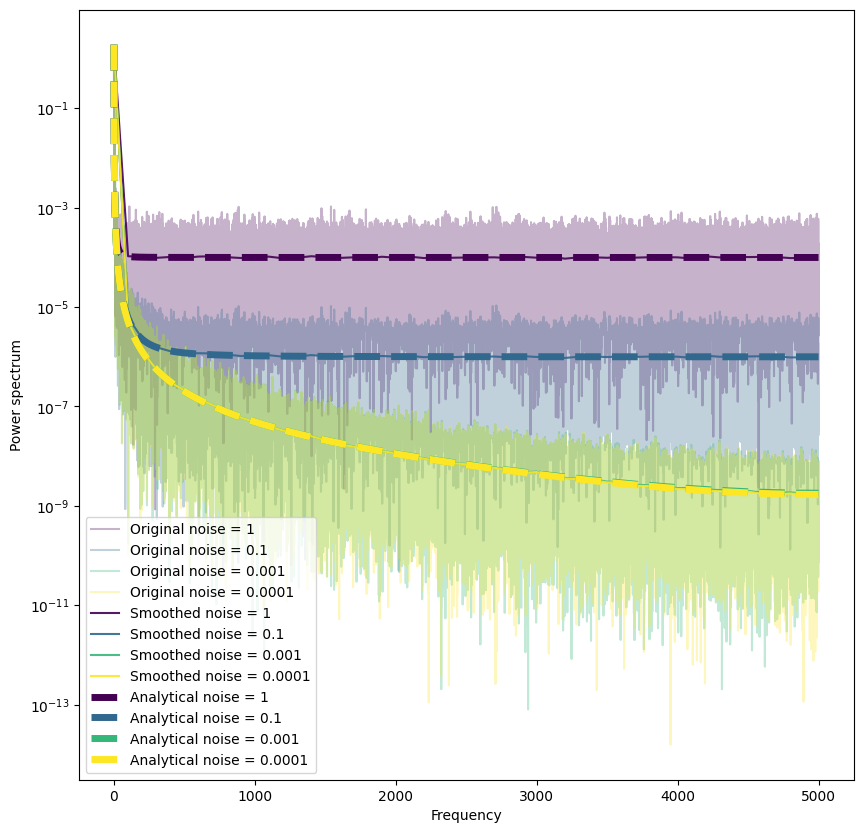

In [20]:
Powerspectra.plot_power_spectra(f_ks_noisy_list, power_spectrum_noisy_list, fit_results, [f"noise = {noise_level}" for noise_level in noise_levels], N_plot_speedup=1000, smoothing_window=1000)